- Eu recebi umas revisões do meu artigo e os revisores falaram bastante da temperatura durante os ciclos das baterias

- Então se a gente conseguisse pegar dados para 3 cenários diferentes, por exemplo, variando a temperatura, seria muito bom

- Nesses dados provavelmente a gente já vai ter os dados de decaimento da capacidade da célula com o passar dos ciclos

- Então o que a gente precisa é pegar esse gráfico, dividir a capacidade em cada ponto pela capacidade total, conseguindo assim o SOH com o passar dos ciclos

- E aí definir o que está sendo variado, por exemplo, seria bom ter esses dados pra **ciclos onde todas as variáveis permanecem constante, mas só a temperatura varia**

- Depois de conseguir esses gráficos, o resto é fácil

In [40]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display


# Oxford
`OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries`

| Cell ID                                | Anode    | Cathode | Source  | Ah   | Form Factor | Temperature (C) | Max SOC | Min SOC | Charge Rate (C) | Discharge Rate (C) |
|----------------------------------------|----------|---------|---------|------|-------------|-----------------|---------|---------|-----------------|--------------------|
| OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries | graphite | LCO     | oxford  | 0.74 | pouch       | 40.00           | 100.00  | 0.00    | 2.00            | 1.84               |

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [41]:
# Header: Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('Battery_Archive_Data/Oxford/OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
df = df[df['Cell_Temperature (C)'] >= 1]

display(df.head(10))
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
1,1.0,0.999,-0.74,4.175,0.000,40.051
2,1.0,1.999,-0.74,4.174,0.000,39.988
3,1.0,2.999,-0.74,4.172,0.000,39.976
4,1.0,3.999,-0.74,4.171,0.000,39.964
5,1.0,4.999,-0.74,4.170,0.001,39.988
6,1.0,5.999,-0.74,4.169,0.001,40.076
7,1.0,6.999,-0.74,4.168,0.001,40.051
8,1.0,7.999,-0.74,4.167,0.001,39.988
9,1.0,8.999,-0.74,4.166,0.001,40.051
10,1.0,9.999,-0.74,4.165,0.002,40.001


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,227455.000000,2.274550e+05,2.274550e+05,227455.000000,227455.000000,227455.000000
mean,3967.207615,2.669858e+07,-7.400000e-01,3.765557,0.305788,40.523928
std,2444.986810,1.680400e+07,2.220451e-16,0.195065,0.179824,0.470356
min,1.000000,9.990000e-01,-7.400000e-01,2.699000,0.000000,39.614000
25%,1900.000000,1.224665e+07,-7.400000e-01,3.656000,0.151000,40.113000
50%,3900.000000,2.608378e+07,-7.400000e-01,3.759000,0.303000,40.400000
75%,6100.000000,4.162771e+07,-7.400000e-01,3.902000,0.455000,40.912000
max,8200.000000,5.517871e+07,-7.400000e-01,4.176000,0.741000,41.699000


## Visualização

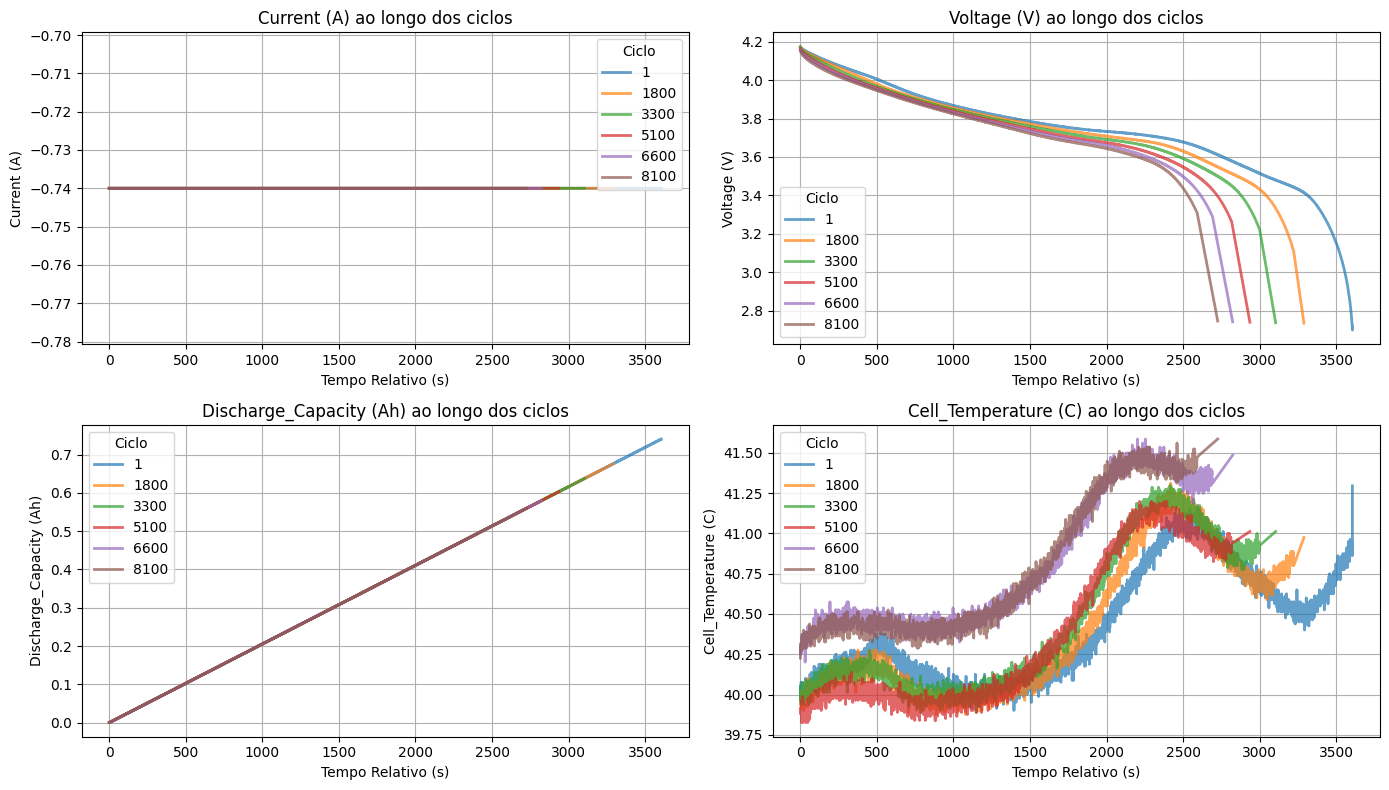

In [42]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Obter os ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)
    
    # Configura os rótulos, título e grade do subplot
    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()



## SOH no decorrer dos ciclos

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

In [43]:
# Definir os valores de capacidade total
# valor maximo de capacidade de descarga
capacidade_total_discharge = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {capacidade_total_discharge} Ah')

# Calculo do SOH
df['SOH_discharge'] = (df['Discharge_Capacity (Ah)'] / capacidade_total_discharge)
df.head()

Capacidade total de descarga: 0.741 Ah


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge
1,1.0,0.999,-0.74,4.175,0.000,40.051,0.00000
2,1.0,1.999,-0.74,4.174,0.000,39.988,0.00000
3,1.0,2.999,-0.74,4.172,0.000,39.976,0.00000
4,1.0,3.999,-0.74,4.171,0.000,39.964,0.00000
5,1.0,4.999,-0.74,4.170,0.001,39.988,0.00135


In [44]:
df_grouped = df.groupby('Cycle_Index', as_index=False).mean()
df_grouped = df_grouped.drop(columns=['Test_Time (s)'])
display(df_grouped.head())
display(df_grouped.describe())

,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge
0,1.0,-0.74,3.734169,0.370422,40.419166,0.499895
1,100.0,-0.74,3.747943,0.360354,40.319742,0.486307
2,200.0,-0.74,3.753684,0.355627,40.317441,0.479929
3,300.0,-0.74,3.755413,0.353264,40.311226,0.476739
4,400.0,-0.74,3.754933,0.351824,40.304815,0.474797


,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge
count,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000
mean,4188.324675,-7.400000e-01,3.766212,0.303210,40.537653,0.409190
std,2448.283784,1.187854e-16,0.007558,0.028160,0.178534,0.038002
min,1.000000,-7.400000e-01,3.734169,0.264266,40.227923,0.356634
25%,2200.000000,-7.400000e-01,3.761675,0.278960,40.379861,0.376464
50%,4200.000000,-7.400000e-01,3.768656,0.298691,40.470904,0.403091
75%,6300.000000,-7.400000e-01,3.771884,0.323048,40.733336,0.435962
max,8200.000000,-7.400000e-01,3.778072,0.370422,40.801851,0.499895


In [45]:
# Inicialmente, definimos o limiar atual a partir do primeiro valor de SOH_discharge.
# A cada queda de 0,01 atingida, atualizaremos este limiar.
last_cycle           = df_grouped["Cycle_Index"][0]
soh_initial          = df_grouped["SOH_discharge"][0]
threshold            = soh_initial - 0.01
cycles_between_drops = []
drop_cycles          = []

# Percorre as linhas do dataframe a partir da segunda linha
for index, row in df_grouped.iterrows():
    # Para controlar casos onde pode cair mais de 1% em um único salto
    while row["SOH_discharge"] <= threshold:
        # Calcular a diferença de ciclos desde a última queda registrada
        cycles_between_drops.append(row["Cycle_Index"] - last_cycle)
        drop_cycles.append(row["Cycle_Index"])
        
        # Atualiza a referência de última queda para o ciclo atual
        last_cycle = row["Cycle_Index"]
        
        # Atualiza para a próxima queda de 1%
        threshold -= 0.01

print("Ciclos com quedas de 1%:", drop_cycles)
print("Ciclos entre cada queda:", cycles_between_drops)

Ciclos com quedas de 1%: [100.0, 300.0, 600.0, 1100.0, 1800.0, 2100.0, 2500.0, 3100.0, 3800.0, 4500.0, 5200.0, 6000.0, 7000.0, 8100.0]
Ciclos entre cada queda: [99.0, 200.0, 300.0, 500.0, 700.0, 300.0, 400.0, 600.0, 700.0, 700.0, 700.0, 800.0, 1000.0, 1100.0]


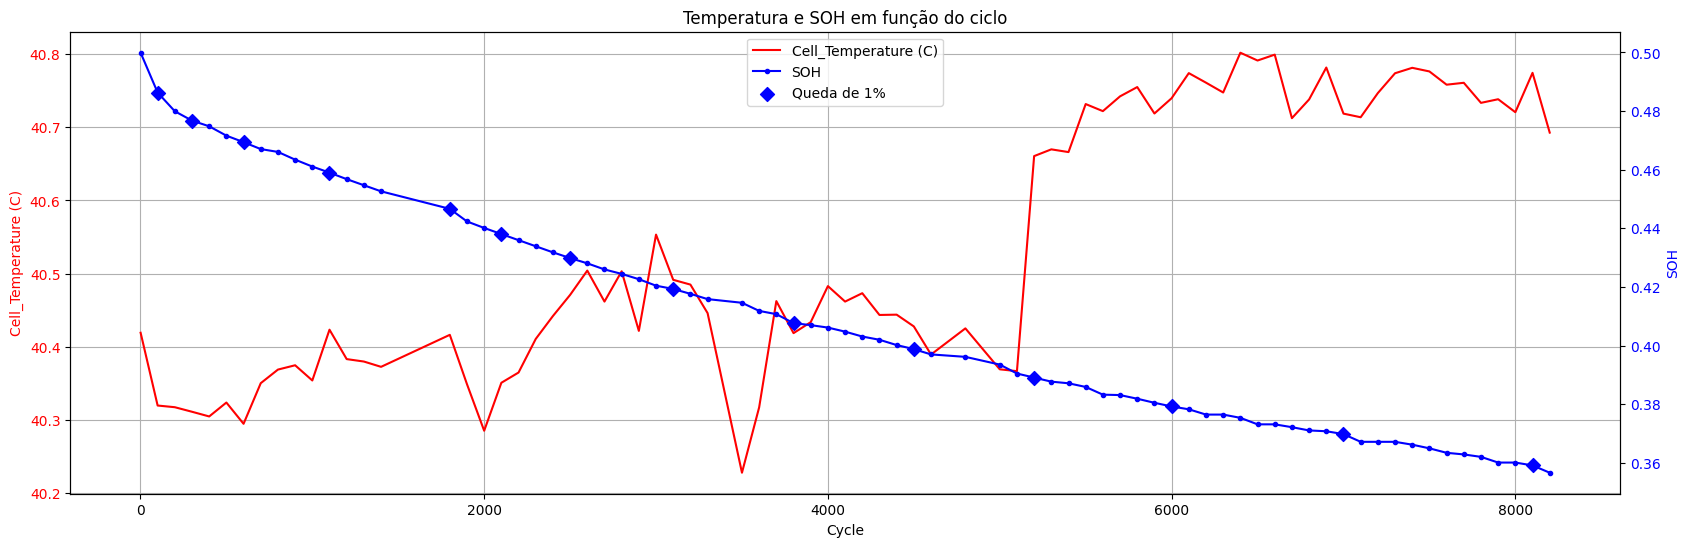

In [46]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20,6))

# Eixo temperatura
ax1.plot(df_grouped["Cycle_Index"], df_grouped["Cell_Temperature (C)"], label="Cell_Temperature (C)", color='red')
ax1.set_xlabel("Cycle")
ax1.set_ylabel("Cell_Temperature (C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

# Eixo SOH
ax2 = ax1.twinx()
ax2.plot(df_grouped["Cycle_Index"], df_grouped["SOH_discharge"], label="SOH", color='blue', marker='.')
ax2.set_ylabel("SOH", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adiciona pontos de marcação nos ciclos presentes em drop_cycles
# Seleciona as linhas do DataFrame onde o Cycle_Index está em drop_cycles
mask = df_grouped["Cycle_Index"].isin(drop_cycles)
ax2.scatter(df_grouped.loc[mask, "Cycle_Index"], 
            df_grouped.loc[mask, "SOH_discharge"], 
            color='blue', marker='D', s=50, label="Queda de 1%")

plt.title("Temperatura e SOH em função do ciclo")

# Legendas: combinando as legendas dos dois eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.show()


Média dos incrementos: 0.4091898670977811
Desvio Padrão dos incrementos: 0.03800245052452878


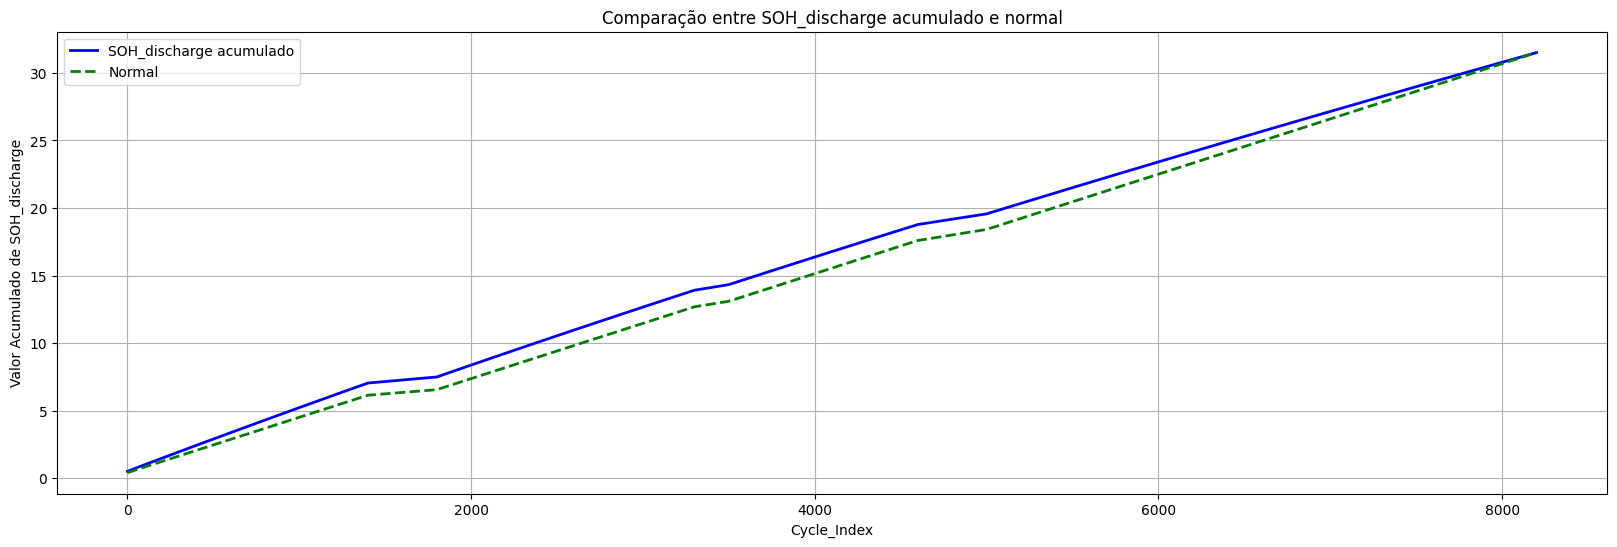

In [60]:
# Calcula a soma acumulada da coluna SOH_discharge.
df_grouped["cum_SOH"] = df_grouped["SOH_discharge"].cumsum()

mean = df_grouped["SOH_discharge"].mean()
std = df_grouped["SOH_discharge"].std()

print("Média dos incrementos:", mean)
print("Desvio Padrão dos incrementos:", std)

# Curva esperada se cada ciclo contribuísse com o valor médio (normal)
expected_cumsum = mean * (np.arange(len(df_grouped)) + 1)

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_grouped["Cycle_Index"], df_grouped["cum_SOH"], label="SOH_discharge acumulado", color="blue", linewidth=2)
ax.plot(df_grouped["Cycle_Index"], expected_cumsum, label="Normal", color="green", linestyle="--", linewidth=2)

ax.set_xlabel("Cycle_Index")
ax.set_ylabel("Valor Acumulado de SOH_discharge")
ax.set_title("Comparação entre SOH_discharge acumulado e normal")
ax.legend(loc='best')
ax.grid(True)

plt.show()
